### EDA and Data Visualizations

In [1]:
# importing pandas and numpy
import pandas as pd
import numpy as np

# importing graphing packages
import seaborn as sns
import matplotlib.pyplot as plt

# importing recommendation system packages
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.prediction_algorithms import knns, SVD, SVDpp
from surprise.similarities import cosine, msd, pearson

In [2]:
movies = pd.read_csv("data/movies.csv")
links = pd.read_csv("data/links.csv")
ratings = pd.read_csv("data/ratings.csv")
tags = pd.read_csv("data/tags.csv")

#### Importing and Exploring Dataset

In [3]:
# taking a look at movies dataset
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
# taking a look at links dataset
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [8]:
films = movies.copy()

In [9]:
films.genres = films.genres.str.split('|')
df = explode(films, ['genres'])
df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure
1,1,Toy Story (1995),Animation
2,1,Toy Story (1995),Children
3,1,Toy Story (1995),Comedy
4,1,Toy Story (1995),Fantasy


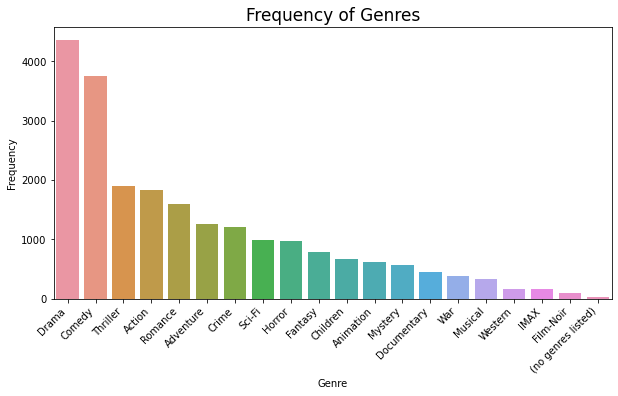

In [11]:
# visualization for frequency of each genre
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=df.genres.value_counts(), x=df.genres.value_counts().index, ax = ax)
ax.set(xlabel="Genre", ylabel = "Frequency")
ax.set_title("Frequency of Genres", size = 17)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

In [12]:
import time
ratings['timestamp'] = ratings['timestamp'].apply(lambda x: time.strftime('%Y', time.localtime(x)))
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,2000
1,1,3,4.0,2000
2,1,6,4.0,2000
3,1,47,5.0,2000
4,1,50,5.0,2000


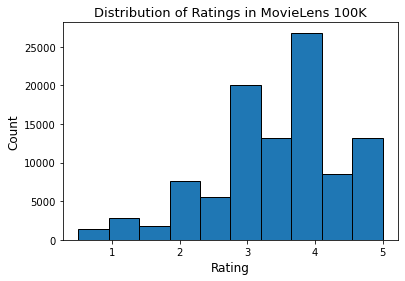

In [13]:
# plotting a histogram of ratings for movies
plt.hist(ratings['rating'], bins=10, ec='black')
plt.xlabel('Rating', size = 12)
plt.ylabel('Count', size = 12)
plt.title('Distribution of Ratings in MovieLens 100K', size =13)
plt.show()
# seems like most movies fall in the 3-4 range, not many that have low ratings (1,2)

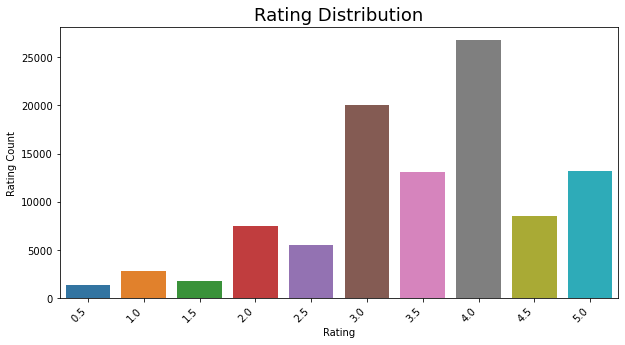

In [51]:
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=ratings.rating.value_counts(), x=ratings.rating.value_counts().index, ax = ax)
ax.set(xlabel="Rating", ylabel = "Rating Count")
ax.set_title("Rating Distribution", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.hlines(data.rating.value_counts().mean(),  -.5 ,9.5 , colors="darkgoldenrod", label="Average Frequency") #plot average price horizontal line\
# plt.legend()
plt.show()

In [41]:
data = ratings.copy().merge(movies.copy(),on='movieId', how='left')

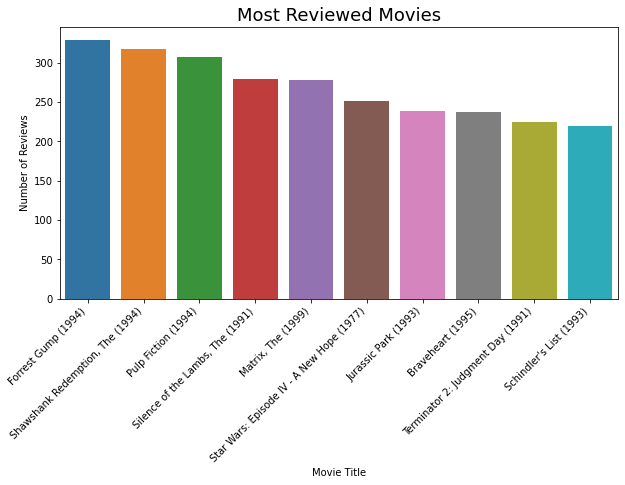

In [42]:
fig_dims=(10,5)
fig, ax = plt.subplots(figsize=fig_dims)
ax = sns.barplot(y=data.title.value_counts()[:10], x=data.title.value_counts(10)[:10].index, ax = ax)
ax.set(xlabel="Movie Title", ylabel = "Number of Reviews")
ax.set_title("Most Reviewed Movies", size=18)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# plt.hlines(data.rating.value_counts().mean(),  -.5 ,9.5 , colors="darkgoldenrod", label="Average Frequency") #plot average price horizontal line\
# plt.legend()
plt.show()

In [16]:
ratings.drop(columns = 'timestamp', inplace = True)

## Modeling 

#### Memory-Based Methods (Neighborhood-Based)

In [17]:
# Split into train and test set
reader = Reader()
ratings_surprise = Dataset.load_from_df(ratings,Reader(rating_scale=(0,5)))

In [18]:
trainset, testset = train_test_split(ratings_surprise, test_size=0.2)

In [19]:
print(len(testset))
print(testset[0])

20168
(380, 4370, 3.0)


In [20]:
sim_pearson = {'name':'pearson', 'user_based':True}
sim_cos = {'name':'cosine','user_based':True}

In [21]:
basic_knn = knns.KNNBasic(sim_options=sim_cos)
basic_knn.fit(trainset)
predictions = basic_knn.test(testset)
accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9720


0.9720130321172772

##### In the aboved cell, the RMSE represents the distance that any predicted rating is from the acural rating. We want this value to be as small as possible. 0.9765 is okay, but we are really hoping for a smaller number. Let's run more models.

In [22]:
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9706
0.9706431799541761


##### After running both pearson and cosine through our model, we can see that cosine preforms a little bit better. We used cosine because our data is sparse (many of our ratings are undefined or 0.

##### One reason why Pearson may have a higher RMSE is because our ratings are all on the same scale.

In [23]:
knn_means = knns.KNNWithMeans(sim_options=sim_cos)
knn_means.fit(trainset)
predictions = knn_means.test(testset)
print(accuracy.rmse(predictions))

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9054
0.9054381945249186


In [24]:
knn_baseline = knns.KNNBaseline(sim_options=sim_cos)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8803
0.8802772978818557


##### After running both KNN means and KNN baseline, KNN baseline is our best performing model.

#### Model-Based Methods (Matrix Factorization)

In [25]:
param_grid = {'n_factors':[75],'n_epochs': [15, 20], 'lr_all': [0.02],
              'reg_all': [0.07, .08]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(ratings_surprise)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:  1.9min remaining:   12.7s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.9min finished


In [26]:
print(gs_model.best_score)
gs_model.best_params

{'rmse': 0.8530832727721129, 'mae': 0.6530204288912811}


{'rmse': {'n_factors': 75, 'n_epochs': 20, 'lr_all': 0.02, 'reg_all': 0.08},
 'mae': {'n_factors': 75, 'n_epochs': 20, 'lr_all': 0.02, 'reg_all': 0.08}}

In [29]:
# matrix factorization
svd = SVD(n_factors=75, n_epochs=20, lr_all=0.02, reg_all=0.08)
svd.fit(trainset)
predictions = svd.test(testset)
print(accuracy.rmse(predictions))

RMSE: 0.8535
0.8534942145982971


#### Predicting User-Ratings of Movies

In [28]:
# predicting what userid 3 would rate movieid 85
user_3_prediction = svd.predict(3, 85)
print(user_3_prediction)
print(movies.title[movies.movieId==85])

user: 3          item: 85         r_ui = None   est = 2.74   {'was_impossible': False}
76    Angels and Insects (1995)
Name: title, dtype: object


In [31]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [34]:
# created a function to predict which movies a particular user would rate the highest
def pred_user_rating(ui):
    if ui in ratings.userId.unique():
        ui_list = ratings[ratings.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = svd.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

In [35]:
# check the preferences of a particular user
predicted_ratings = pred_user_rating(10)
predicted_ratings

,ratings
movies,
"Three Billboards Outside Ebbing, Missouri (2017)",4.548573
Grave of the Fireflies (Hotaru no haka) (1988),4.458321
Adam's Rib (1949),4.416611
Elite Squad (Tropa de Elite) (2007),4.408925
"Discreet Charm of the Bourgeoisie, The (Charme discret de la bourgeoisie, Le) (1972)",4.405897
Eastern Promises (2007),4.357671
Fright Night (1985),4.339200
"Spy Who Loved Me, The (1977)",4.274124
"Girl with the Dragon Tattoo, The (Män som hatar kvinnor) (2009)",4.249357


##### Here we input userid (3) and movie id (85) in order to get the predicted rating this particular individual would rate movie id #85.

#### Recommending Movies for Users

In [36]:
# make predictions for the user
# you'll probably want to create a list of tuples in the format (movie_id, predicted_score)
def ranked_movies(ui):
    list_of_movies = []
    for m_id in movies['movieId'].unique():
        list_of_movies.append( (m_id,svd.predict(ui,m_id)[3]))
# order the predictions from highest to lowest rated
    ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
    return ranked_movies

# recommending movies for particular user
def recommended_movies(user_ratings,movie_title_df,n):
        for idx, rec in enumerate(user_ratings):
            title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break

##### The first function ranks the movies for a particular individual from highest predicted rating to lower predicted rating.

##### The second function brings in the title of a particular movie based on the movieId and lists the top 5 movies for that particular individual

In [38]:
# instantiating function
recommended_movies(ranked_movies(6),movies,5)

Recommendation #  1 :  2410    Last Detail, The (1973)
Name: title, dtype: object 

Recommendation #  2 :  2582    Guess Who's Coming to Dinner (1967)
Name: title, dtype: object 

Recommendation #  3 :  9497    Band of Brothers (2001)
Name: title, dtype: object 

Recommendation #  4 :  9618    Three Billboards Outside Ebbing, Missouri (2017)
Name: title, dtype: object 

Recommendation #  5 :  7166    Mary and Max (2009)
Name: title, dtype: object 



##### Userid 6 would be recommended the following movies. Recommendation #1 is the movie the function thinks the user will like best

#### Movie Rater Function

In [39]:
# this is more of a fun side project. this function will give you back a new movie once you have rated the one before
def movie_rater(movie_df,num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID,'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [40]:
user_rating = movie_rater(movies, 4, 'Comedy')

      movieId                       title          genres
1685     2266  Butcher's Wife, The (1991)  Comedy|Romance


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 5


      movieId                                          title  genres
6114    42740  Looking for Comedy in the Muslim World (2005)  Comedy


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 3


      movieId                             title              genres
8844   132454  Girltrash: All Night Long (2014)  Comedy|Crime|Drama


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 4


      movieId         title                genres
4462     6587  Gigli (2003)  Comedy|Crime|Romance


How do you rate this movie on a scale of 1-5, press n if you have not seen :
 4
